In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/4/41/Chicken.jpg https://raw.githubusercontent.com/zer0sh0t/artificial_intelligence/master/vision_models/vision_transformer/cifar_10_dataset/test_images/dog.jpg

In [2]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image, ImageFilter, ImageChops

In [3]:
plt.rcParams["figure.figsize"] = (15, 15)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preprocess = transforms.Compose(
    [
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ]
)
deprocess = lambda img: img * torch.tensor(std).to(img.device) + torch.tensor(mean).to(img.device)
print(device)

cuda


In [5]:
net = models.vgg16(pretrained=True).to(device)
for param in net.parameters():
    param.requires_grad = False

module_list = list(net.features.modules()).pop(0) # 0th element is the entire neural net module
print(module_list[:4], len(module_list))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
) 31


In [9]:
def deep_dream(img, layer, iters, lr, octave_scale, num_octaves):
    if num_octaves > 0:
        img1 = img.filter(ImageFilter.GaussianBlur(2))

        if img1.size[0] / octave_scale < 1 or img1.size[1] / octave_scale < 1:
            inter_size = img1.size
        else:
            inter_size = (int(img1.size[0] / octave_scale), int(img1.size[1] / octave_scale))
            
        img1 = img1.resize(inter_size, Image.ANTIALIAS)
        img1 = deep_dream(img1, layer, iters, lr, octave_scale, num_octaves-1)
        og_size = (img.size[0], img.size[1])
        img1 = img1.resize(og_size, Image.ANTIALIAS)
        img = ImageChops.blend(img, img1, 0.6) # blends the 2 imgs into one, to stabilize the img quality

    print(f'octave lvl: {num_octaves}')
    img_dd = preprocess(img).unsqueeze(0).to(device)
    img_dd.requires_grad_(True)
    net.zero_grad()

    for _ in range(iters):
        out = img_dd
        for layer_id in range(layer):
            out = module_list[layer_id](out)
        loss = out.norm()
        loss.backward()
        img_dd.data = img_dd.data + lr * img_dd.grad.data # gradient ascent on the img
    
    img_dd = img_dd.data.squeeze(0)
    img_dd = img_dd.permute(1, 2, 0)
    img_dd = deprocess(img_dd)
    img_dd = np.clip(img_dd.cpu(), 0, 1)
    img_dd = Image.fromarray(np.uint8(img_dd * 255))
    out_img = img_dd.resize(img.size)
    return out_img

In [10]:
def plot_results(img_path, layer, iters, lr, octave_scale, num_octaves):
    img = Image.open(img_path)
    out_img = deep_dream(img, layer, iters, lr, octave_scale, num_octaves)
    plt.subplot(121)
    plt.title('original img')
    plt.imshow(img)
    plt.subplot(122)
    plt.title('deep dream img')
    plt.imshow(out_img)
    plt.show()

octave lvl: 0
octave lvl: 1
octave lvl: 2
octave lvl: 3
octave lvl: 4
octave lvl: 5
octave lvl: 6
octave lvl: 7
octave lvl: 8
octave lvl: 9
octave lvl: 10


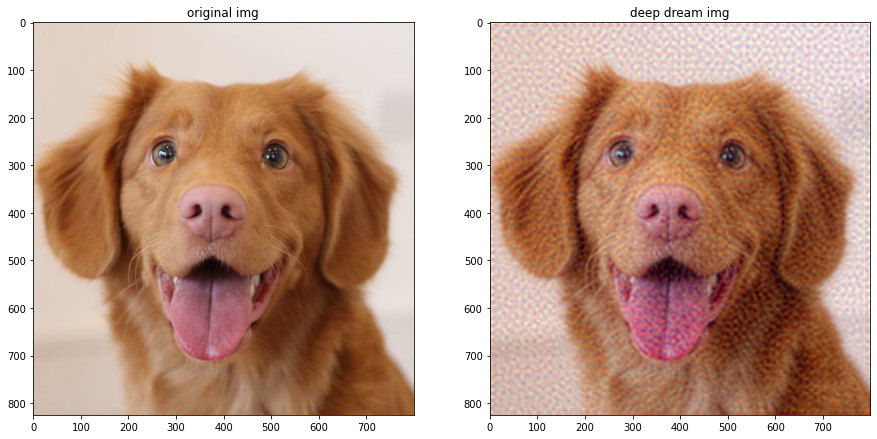

In [11]:
plot_results('dog.jpg', 5, 5, 0.2, 2, 10)

octave lvl: 0
octave lvl: 1
octave lvl: 2
octave lvl: 3
octave lvl: 4
octave lvl: 5
octave lvl: 6
octave lvl: 7
octave lvl: 8
octave lvl: 9
octave lvl: 10
octave lvl: 11
octave lvl: 12


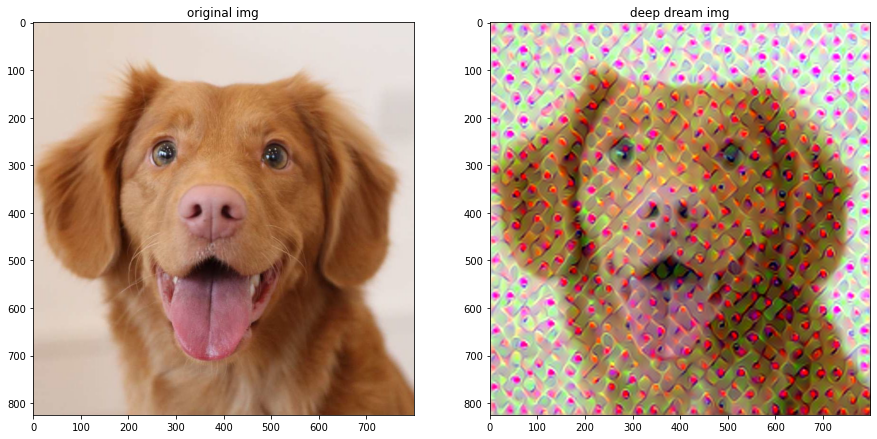

In [20]:
plot_results('dog.jpg', 10, 8, 0.1, 2, 12)

octave lvl: 0
octave lvl: 1
octave lvl: 2
octave lvl: 3
octave lvl: 4
octave lvl: 5
octave lvl: 6
octave lvl: 7
octave lvl: 8
octave lvl: 9
octave lvl: 10


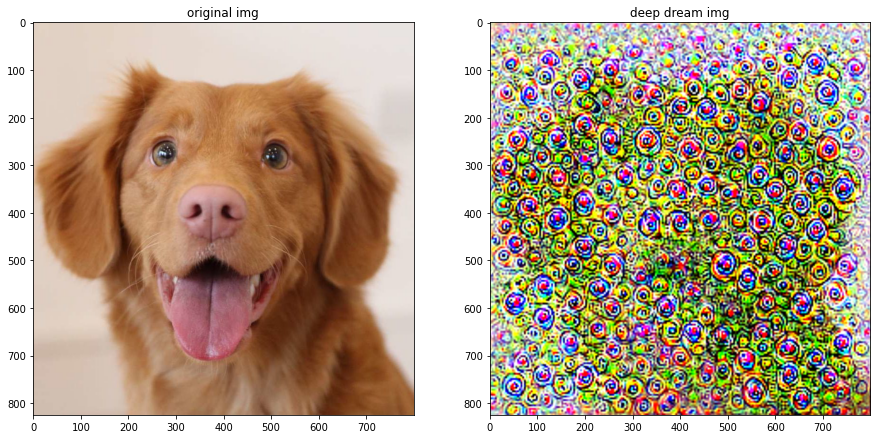

In [13]:
plot_results('dog.jpg', 20, 5, 0.2, 2, 10)

octave lvl: 0
octave lvl: 1
octave lvl: 2
octave lvl: 3
octave lvl: 4
octave lvl: 5
octave lvl: 6
octave lvl: 7
octave lvl: 8
octave lvl: 9
octave lvl: 10
octave lvl: 11
octave lvl: 12
octave lvl: 13
octave lvl: 14
octave lvl: 15
octave lvl: 16
octave lvl: 17
octave lvl: 18
octave lvl: 19
octave lvl: 20


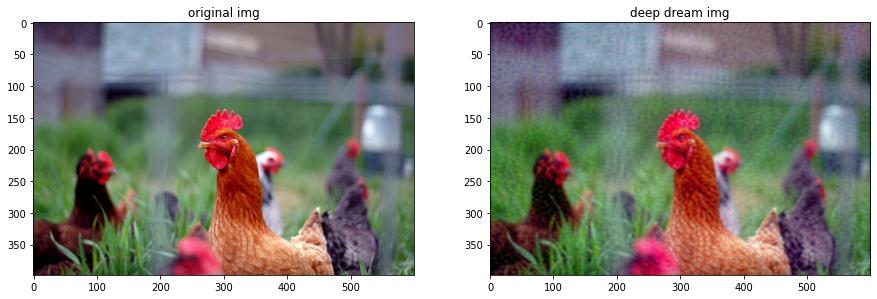

In [18]:
plot_results('Chicken.jpg', 5, 5, 0.2, 2, 20)

octave lvl: 0
octave lvl: 1
octave lvl: 2
octave lvl: 3
octave lvl: 4
octave lvl: 5
octave lvl: 6
octave lvl: 7
octave lvl: 8
octave lvl: 9
octave lvl: 10


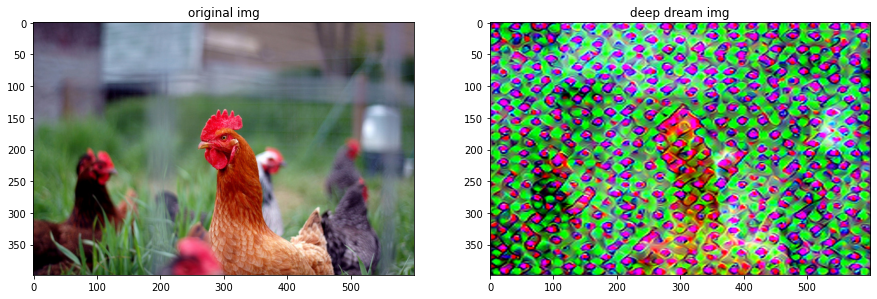

In [19]:
plot_results('Chicken.jpg', 10, 10, 0.3, 2, 10)

octave lvl: 0
octave lvl: 1
octave lvl: 2


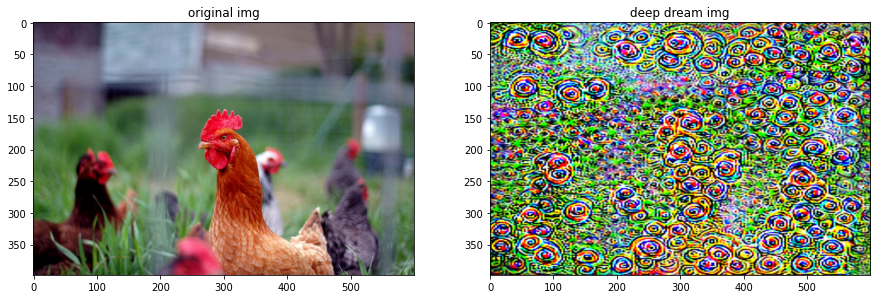

In [21]:
plot_results('Chicken.jpg', 20, 10, 0.1, 2, 2)